# Analysis of Microglia data


In [37]:
# Setup
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.model import other_models as om

Load and format data: 

4 control samples, 2 samples for other conditions each; 8 cell types

In [38]:
cell_counts = pd.read_csv("../../data/cell_count_microglia_AD_WT_location.csv", index_col=0)
# Sort values such that wild type is considered the base category
print(cell_counts)

data_cer = dat.from_pandas(cell_counts.loc[cell_counts["location"] == "cerebellum"], 
                           covariate_columns=["mouse_type", "location", "replicate"])
data_cor = dat.from_pandas(cell_counts.loc[cell_counts["location"] == "cortex"], 
                           covariate_columns=["mouse_type", "location", "replicate"])

  mouse_type    location replicate  microglia 1  microglia 2  microglia 3
0         AD  cerebellum    mouse1          709            5            2
1         AD  cerebellum    mouse2          715            7            6
2         AD      cortex    mouse1          834           19           59
3         AD      cortex    mouse2          794           16          100
4         WT  cerebellum    mouse1          449            3            2
5         WT  cerebellum    mouse2          424            3            4
6         WT      cortex    mouse1          412            0            0
7         WT      cortex    mouse2          581            1            1


Plot data:

      location mouse_type     variable     value
4   cerebellum         WT  microglia 1  0.988987
5   cerebellum         WT  microglia 1  0.983759
12  cerebellum         WT  microglia 2  0.006608
13  cerebellum         WT  microglia 2  0.006961
20  cerebellum         WT  microglia 3  0.004405
21  cerebellum         WT  microglia 3  0.009281
0   cerebellum         AD  microglia 1  0.990223
1   cerebellum         AD  microglia 1  0.982143
8   cerebellum         AD  microglia 2  0.006983
9   cerebellum         AD  microglia 2  0.009615
16  cerebellum         AD  microglia 3  0.002793
17  cerebellum         AD  microglia 3  0.008242
6       cortex         WT  microglia 1  1.000000
7       cortex         WT  microglia 1  0.996569
14      cortex         WT  microglia 2  0.000000
15      cortex         WT  microglia 2  0.001715
22      cortex         WT  microglia 3  0.000000
23      cortex         WT  microglia 3  0.001715
2       cortex         AD  microglia 1  0.914474
3       cortex      

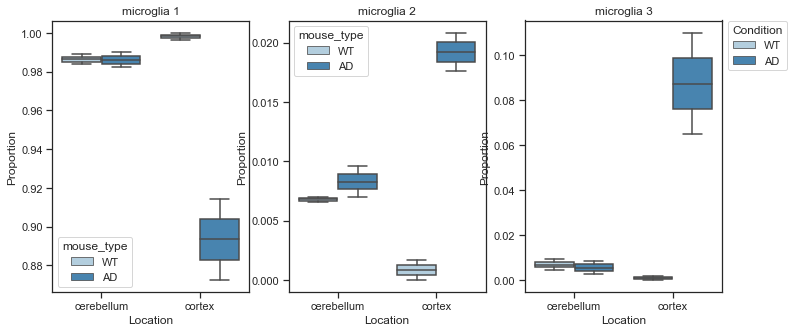

In [39]:
# Count data to ratios
counts = cell_counts.iloc[:, 3:]
rowsum = np.sum(counts, axis=1)

ratios = counts.div(rowsum, axis=0)
ratios["mouse_type"] = cell_counts["mouse_type"]
ratios["location"] = cell_counts["location"]

# Make boxplots
fig, ax = plt.subplots(figsize=(12,5), ncols=3)
df = pd.melt(ratios, id_vars=['location', "mouse_type"], value_vars=ratios.columns[:3])
df = df.sort_values(["location", "mouse_type"], ascending=[True, False])
print(df)
sns.set_context('notebook')
sns.set_style('ticks')
for i in range(3):
    d = sns.boxplot(x='location', y = 'value', hue="mouse_type",
                    data=df.loc[df["variable"]==f"microglia {i+1}"], fliersize=1,
                    palette='Blues', ax=ax[i])

    d.set_ylabel('Proportion')
    loc, labels = plt.xticks()
    d.set_xlabel('Location')
    d.set_title(f"microglia {i+1}")
plt.legend(bbox_to_anchor=(1.33, 1), borderaxespad=0., title="Condition")

# plt.savefig(plot_path + "haber_boxes_blue.svg", format="svg", bbox_inches="tight")
# plt.savefig(plot_path + "haber_boxes_blue.png", format="png", bbox_inches="tight")

plt.show()

Analyze cerebellum data:
Apply scCODA for every cell type set as the reference.

In [40]:
# Use this formula to make a wild type -> treated comparison, not the other way
formula = "C(mouse_type, levels=['WT', 'AD'])"


# cerebellum
res_cer = []
effects_cer = pd.DataFrame(index=data_cer.var.index.copy(),
                           columns=data_cer.var.index.copy())
effects_cer.index.rename("cell type", inplace=True)
effects_cer.columns.rename("reference", inplace=True)

for ct in data_cer.var.index:
    print(f"Reference: {ct}")
    
    model = mod.CompositionalAnalysis(data=data_cer, formula=formula, reference_cell_type=ct)
    results = model.sample_hmc()
    _, effect_df = results.summary_prepare()
    res_cer.append(results)
    effects_cer[ct] = effect_df.loc[:, "Final Parameter"].array
  

Reference: microglia 1
MCMC sampling finished. (52.146 sec)
Acceptance rate: 55.2%
Reference: microglia 2
MCMC sampling finished. (51.326 sec)
Acceptance rate: 52.1%
Reference: microglia 3
MCMC sampling finished. (50.422 sec)
Acceptance rate: 53.3%


In [41]:
# Column: Reference category
# Row: Effect
print(effects_cer)
    

reference    microglia 1  microglia 2  microglia 3
cell type                                         
microglia 1          0.0          0.0          0.0
microglia 2          0.0          0.0          0.0
microglia 3          0.0          0.0          0.0


Now with cortex data:

In [42]:
# cortex
res_cor = []
effects_cor = pd.DataFrame(index=data_cor.var.index.copy(),
                           columns=data_cor.var.index.copy())
effects_cor.index.rename("cell type", inplace=True)
effects_cor.columns.rename("reference", inplace=True)

for ct in data_cer.var.index:
    print(f"Reference: {ct}")
    
    model = mod.CompositionalAnalysis(data=data_cor, formula=formula, reference_cell_type=ct)
    results = model.sample_hmc()
    _, effect_df = results.summary_prepare()
    res_cor.append(results)
    effects_cor[ct] = effect_df.loc[:, "Final Parameter"].array
    

Reference: microglia 1
Zero counts encountered in data! Added a pseudocount of 0.5.
MCMC sampling finished. (52.420 sec)
Acceptance rate: 50.9%
Reference: microglia 2
Zero counts encountered in data! Added a pseudocount of 0.5.
MCMC sampling finished. (51.033 sec)
Acceptance rate: 50.4%
Reference: microglia 3
Zero counts encountered in data! Added a pseudocount of 0.5.
MCMC sampling finished. (50.918 sec)
Acceptance rate: 48.8%


In [43]:
# Column: Reference category
# Row: Effect
effects_cor.index.name = "cell type"
effects_cor.columns.name = "reference"
print(effects_cor)


reference    microglia 1  microglia 2  microglia 3
cell type                                         
microglia 1     0.000000    -2.721081    -3.140219
microglia 2     1.834133     0.000000    -0.484056
microglia 3     2.856714     1.215256     0.000000


For validataion, apply ancom to the same dataset.
We see also no changes for the cerebellum data, and a change in Microglia 2 and 3 for the cortex data.

In [44]:
cer_ancom = data_cer.copy()
cer_ancom.obs = cer_ancom.obs.rename(columns={"mouse_type": "x_0"})
ancom_cer = om.AncomModel(cer_ancom)
ancom_cer.fit_model()
print(ancom_cer.ancom_out)

cor_ancom = data_cor.copy()
cor_ancom.obs = cor_ancom.obs.rename(columns={"mouse_type": "x_0"})
cor_ancom.X = cor_ancom.X + 0.5
ancom_cor = om.AncomModel(cor_ancom)
ancom_cor.fit_model()
print(ancom_cor.ancom_out)

(   W  Reject null hypothesis
0  0                   False
1  0                   False
2  0                   False, Percentile  0.0    25.0   50.0   75.0   100.0  0.0     25.0   50.0    75.0   \
Group          AD     AD     AD     AD     AD     WT      WT     WT      WT   
0           709.0  710.5  712.0  713.5  715.0  424.0  430.25  436.5  442.75   
1             5.0    5.5    6.0    6.5    7.0    3.0    3.00    3.0    3.00   
2             2.0    3.0    4.0    5.0    6.0    2.0    2.50    3.0    3.50   

Percentile  100.0  
Group          WT  
0           449.0  
1             3.0  
2             4.0  )
(   W  Reject null hypothesis
0  2                    True
1  1                   False
2  1                   False, Percentile  0.0     25.0   50.0    75.0   100.0  0.0     25.0   50.0    75.0   \
Group          AD      AD     AD      AD     AD     WT      WT     WT      WT   
0           794.5  804.50  814.5  824.50  834.5  412.5  454.75  497.0  539.25   
1            16.5   17.2